# Setup

In [ ]:
# --- Reproducibility ---
import os, random, numpy as np

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"

random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

In [ ]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

# --- General Libraries ---
import pandas as pd
import gc
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings
warnings.filterwarnings("ignore")

# --- Scikit-learn ---
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

# --- TensorFlow / Keras ---
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, Embedding, Dense
from tensorflow.python.ops.math_ops import reduce_prod

# --- Other ---
import string
import re

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Loading

In [ ]:
# Path to your file
file_path = "/content/drive/My Drive/Colab Notebooks/DLI Assignment/fake_job_postings.csv"

df = pd.read_csv(file_path)

print(df.head())

   job_id                                      title            location  \
0       1                           Marketing Intern    US, NY, New York   
1       2  Customer Service - Cloud Video Production      NZ, , Auckland   
2       3    Commissioning Machinery Assistant (CMA)       US, IA, Wever   
3       4          Account Executive - Washington DC  US, DC, Washington   
4       5                        Bill Review Manager  US, FL, Fort Worth   

  department salary_range                                    company_profile  \
0  Marketing          NaN  We're Food52, and we've created a groundbreaki...   
1    Success          NaN  90 Seconds, the worlds Cloud Video Production ...   
2        NaN          NaN  Valor Services provides Workforce Solutions th...   
3      Sales          NaN  Our passion for improving quality of life thro...   
4        NaN          NaN  SpotSource Solutions LLC is a Global Human Cap...   

                                         description  \
0  Foo

# Pre processing

In [ ]:
# ===== Pre-processing =====

# Remove columns that are not needed for analysis or modeling
# 'job_id'  -> unique identifier (not useful for prediction)
# 'department' and 'salary_range' -> possibly irrelevant or too sparse
df.drop(columns=['job_id', 'department', 'salary_range'], inplace=True)

# Split the 'location' column by commas into separate parts
# Example: "New York, NY, USA" -> ["New York", "NY", "USA"]
df_loc = pd.DataFrame(df.location.str.split(",", expand=True))

# Keep only the first part (e.g., city name) and assign back to 'location'
df['location'] = df_loc[0]

# Replace all missing values in the DataFrame with 'UNK' (Unknown)
# This prevents errors during text processing and marks missing info
df = df.fillna('UNK')

# Create a new column 'full_text' by concatenating multiple text fields
# This merges title, company profile, job description, requirements, and benefits
# into a single unified string for NLP/text-based model input
df['full_text'] = (
    df.title +
    df.company_profile +
    df.description +
    df.requirements +
    df.benefits
)

In [ ]:
# List of categorical columns to be converted into numeric format
# These contain string labels that need to be encoded for ML models
cat_cols = [
    'industry',
    'function',
    'required_education',
    'employment_type',
    'required_experience',
    'location'
]

# Perform One-Hot Encoding on the specified categorical columns
# This will replace each column with multiple binary (0/1) columns,
# one for each unique category value in that column
# Example: "employment_type" → "employment_type_Full-time", "employment_type_Part-time", etc.
df = pd.get_dummies(df, columns=cat_cols)

# Display the new shape of the DataFrame after encoding
# Rows stay the same, columns increase due to the newly created binary columns
print('Shape after one-hot-encoding:', df.shape)

# Display the first row of the DataFrame to verify encoding results
df.head(1)

Shape after one-hot-encoding: (17880, 299)


,title,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,fraudulent,full_text,...,location_TT,location_TW,location_UA,location_UG,location_UNK,location_US,location_VI,location_VN,location_ZA,location_ZM
0,Marketing Intern,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,UNK,0,1,0,0,"Marketing InternWe're Food52, and we've create...",...,False,False,False,False,False,True,False,False,False,False


# Model

In [ ]:
# ===== Custom Text Standardization Function =====
def custom_standardization(input_data):
    # Convert all text to lowercase to make model case-insensitive
    lowercase = tf.strings.lower(input_data)

    # Replace HTML line breaks (<br />) with a space
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')

    # Remove all punctuation characters using regex
    # re.escape ensures punctuation symbols are safely handled in the pattern
    return tf.strings.regex_replace(
        stripped_html,
        '[%s]' % re.escape(string.punctuation),
        ''
    )

# ===== Tokenization & Vectorization Parameters =====
max_features = 10000       # Only keep the top 10,000 most frequent words in the vocabulary
embedding_dim = 128        # Dimension of the word embedding vectors
sequence_length = 1000     # All text sequences will be padded/truncated to 1,000 tokens

# ===== Text Vectorization Layer =====
vectorize = TextVectorization(
    standardize=custom_standardization,   # Apply custom cleaning before tokenizing
    max_tokens=max_features,              # Limit vocabulary size to most frequent words
    output_mode='int',                     # Output integer IDs for each token
    output_sequence_length=sequence_length # Pad/trim each sequence to exactly 1,000 tokens
)

# Build the vocabulary for the TextVectorization layer using our dataset
# This scans all text in df.full_text, cleans it, tokenizes it,
# and stores the top 'max_features' most frequent words in the vocabulary.
# After this, vectorize(...) will map words → integer IDs consistently.
vectorize.adapt(df.full_text)

In [ ]:
# ===== Step 1: Split into train+val (80%) and test (20%), preserving class ratios
train_val, test = train_test_split(
    df,
    train_size=0.8,
    random_state=SEED, # use the same global seed
    shuffle=True,
    stratify=df.fraudulent.values  # ensures same fraud/non-fraud ratio
)

# ===== Step 2: Split train+val into train (80%) and validation (20%), preserving class ratios
train, val = train_test_split(
    train_val,
    train_size=0.8,
    random_state=SEED,
    shuffle=True,
    stratify=train_val.fraudulent.values
)

# Display shapes for verification
print("train shape:", train.shape)  # ~64% of data
print("val shape:", val.shape)      # ~16% of data
print("test shape:", test.shape)    # ~20% of data

# ===== Step 3: Identify numeric feature columns
numeric_cols = train.columns  # start with all columns
numeric_cols = numeric_cols.drop([
    'title',            # text
    'company_profile',  # text
    'requirements',     # text
    'full_text',        # combined text field
    'description',      # text
    'benefits',         # text
    'fraudulent'        # target variable
])

# Number of numeric columns after removing text and target
len(numeric_cols)

train shape: (11443, 299)
val shape: (2861, 299)
test shape: (3576, 299)


292

In [ ]:
# ===== Extract text-based features for Train / Validation / Test =====

# Combined text column (title + description + requirements + etc.)
train_full_text = train.full_text
val_full_text   = val.full_text
test_full_text  = test.full_text

# Job title
train_title = train.title
val_title   = val.title
test_title  = test.title

# Job requirements section
train_requirements = train.requirements
val_requirements   = val.requirements
test_requirements  = test.requirements

# Job description section
train_description = train.description
val_description   = val.description
test_description  = test.description

# Company profile text
train_company_profile = train.company_profile
val_company_profile   = val.company_profile
test_company_profile  = test.company_profile

# Benefits section
train_benefits = train.benefits
val_benefits   = val.benefits
test_benefits  = test.benefits

# ===== Extract numeric feature arrays =====
# Select only numeric feature columns (from numeric_cols) and convert to NumPy arrays
train_numeric = train[numeric_cols].values
val_numeric   = val[numeric_cols].values
test_numeric  = test[numeric_cols].values

# ===== Extract target labels =====
# 'fraudulent' column is the binary target (1 = fake job, 0 = real job)
y_train = train.fraudulent
y_val   = val.fraudulent
y_test  = test.fraudulent

In [ ]:
# ===== Combine numeric and vectorized text features for TRAIN =====

# Shape of numeric feature array (rows = samples, cols = numeric features)
np.array(train[numeric_cols]).shape

# Shape of vectorized full_text (rows = samples, cols = sequence_length from TextVectorization)
vectorize(train_full_text).shape

# Concatenate numeric features and vectorized text along columns (axis=1)
X_train = np.concatenate(
    (np.array(train[numeric_cols]), vectorize(train_full_text)),
    axis=1
)

# Final combined input shape for training
X_train.shape

(11443, 1292)

In [ ]:
# ===== Combine numeric and vectorized text features for TEST =====

np.array(test[numeric_cols]).shape
vectorize(test_full_text).shape

X_test = np.concatenate(
    (np.array(test[numeric_cols]), vectorize(test_full_text)),
    axis=1
)

X_test.shape

(3576, 1292)

In [ ]:
# =========================
# 1) Imports & Config
# =========================
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM,
                                     Dense, Dropout, Concatenate)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Model hyperparameters
MAXLEN      = 200      # Max number of tokens per text input
MAX_VOCAB   = 30000    # Max vocabulary size (most frequent words kept)
EMBED_DIM   = 64      # Embedding vector dimension
LSTM_UNITS  = 32       # Number of units in LSTM
DROPOUT_P   = 0.4      # Dropout rate for regularization

# =========================
# 2) Helpers
# =========================
def to_list_str(x):
    """
    Convert input (Series, list, etc.) to a list of strings, replacing NaNs with empty strings.
    Ensures consistent data type before tokenization.
    """
    return pd.Series(x).fillna("").astype(str).tolist()

def encode_with_shared_tokenizer(tok, tr_txt, va_txt, maxlen=MAXLEN):
    """
    Tokenize and pad both training and validation text using the SAME tokenizer.
    Ensures both sets use the same word index mapping.
    """
    # Convert to sequences of integers
    tr = tok.texts_to_sequences(to_list_str(tr_txt))
    va = tok.texts_to_sequences(to_list_str(va_txt))

    # Pad/truncate to fixed length for LSTM
    tr = pad_sequences(tr, maxlen=maxlen, padding="post", truncating="post").astype("int32")
    va = pad_sequences(va, maxlen=maxlen, padding="post", truncating="post").astype("int32")
    return tr, va

# =========================
# 3) Build ONE shared tokenizer over ALL training text
# =========================
# Combine all text fields into one big list to fit tokenizer
train_all_text = (
    to_list_str(train_title)
    + to_list_str(train_company_profile)
    + to_list_str(train_description)
    + to_list_str(train_benefits)
    + to_list_str(train_requirements)
)

# Create tokenizer (with OOV token for unknown words)
tok = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tok.fit_on_texts(train_all_text)  # Learn word index from all training text

# Encode + pad each field separately
train_title_enc,           val_title_enc            = encode_with_shared_tokenizer(tok, train_title,           val_title)
train_company_profile_enc, val_company_profile_enc  = encode_with_shared_tokenizer(tok, train_company_profile, val_company_profile)
train_description_enc,     val_description_enc      = encode_with_shared_tokenizer(tok, train_description,     val_description)
train_benefits_enc,        val_benefits_enc         = encode_with_shared_tokenizer(tok, train_benefits,        val_benefits)
train_requirements_enc,    val_requirements_enc     = encode_with_shared_tokenizer(tok, train_requirements,    val_requirements)

# =========================
# 4) Numeric features & labels
# =========================

MAXLEN = 200
oov_idx = tok.word_index.get("<OOV>", 1)  # Index for OOV token (default to 1)

def enforce_right_padding(x, maxlen=MAXLEN):
    """
    Ensures tokens are placed at the start, padding zeros at the end.
    Avoids cases where zeros appear in the middle of sequences.
    """
    x = np.asarray(x, dtype="int32")
    out = np.zeros_like(x)
    for i in range(x.shape[0]):
        nz = x[i][x[i] != 0]   # Keep non-zero tokens
        nz = nz[:maxlen]       # Truncate if too long
        out[i, :len(nz)] = nz  # Place tokens first
    return out

def fix_all_zero_rows(x, fill=oov_idx):
    """
    If a row is entirely zeros (empty text), replace first token with OOV.
    This prevents mask_zero from ignoring the entire sequence.
    """
    x = np.asarray(x, dtype="int32")
    all_zero = (x.sum(axis=1) == 0)
    if np.any(all_zero):
        x[all_zero, 0] = fill
    return x

def sanitize(x):
    """
    Apply right-padding enforcement and zero-row fixing.
    """
    x = enforce_right_padding(x, MAXLEN)
    x = fix_all_zero_rows(x, oov_idx)
    return x

# Sanitize all training & validation sequences
train_title_enc           = sanitize(train_title_enc)
val_title_enc             = sanitize(val_title_enc)
train_company_profile_enc = sanitize(train_company_profile_enc)
val_company_profile_enc   = sanitize(val_company_profile_enc)
train_description_enc     = sanitize(train_description_enc)
val_description_enc       = sanitize(val_description_enc)
train_benefits_enc        = sanitize(train_benefits_enc)
val_benefits_enc          = sanitize(val_benefits_enc)
train_requirements_enc    = sanitize(train_requirements_enc)
val_requirements_enc      = sanitize(val_requirements_enc)

# Optional diagnostics: check for bad rows
def count_bad_rows(x):
    """
    Counts rows where zeros appear between non-zero tokens (invalid padding).
    """
    bad = 0
    for row in x:
        zero_seen = False
        for t in row:
            if t == 0: zero_seen = True
            elif zero_seen:
                bad += 1; break
    return bad

# Print diagnostics for each dataset
for name, arr in [
    ("title", train_title_enc), ("company", train_company_profile_enc),
    ("description", train_description_enc), ("benefits", train_benefits_enc),
    ("requirements", train_requirements_enc),
    ("val_title", val_title_enc), ("val_company", val_company_profile_enc),
    ("val_description", val_description_enc), ("val_benefits", val_benefits_enc),
    ("val_requirements", val_requirements_enc),
]:
    print(name, "bad rows:", count_bad_rows(arr),
          "all-zero rows after fix:", np.sum(arr.sum(axis=1)==oov_idx))

# Convert numeric features to float32 arrays
train_numeric = np.asarray(train_numeric, dtype="float32")
val_numeric   = np.asarray(val_numeric,   dtype="float32")

# Ensure numeric arrays are 2D
if train_numeric.ndim == 1: train_numeric = train_numeric.reshape(-1, 1)
if val_numeric.ndim   == 1: val_numeric   = val_numeric.reshape(-1, 1)

# Convert labels to float32 column vectors
y_train = np.asarray(y_train, dtype="float32").reshape(-1, 1)
y_val   = np.asarray(y_val,   dtype="float32").reshape(-1, 1)

# =========================
# 5) Build the model (shared Embedding across fields)
# =========================
# Define inputs
numeric_in      = Input(shape=(train_numeric.shape[1],), dtype="float32", name="numeric_in")
title_in        = Input(shape=(MAXLEN,), dtype="int32", name="title_in")
company_in      = Input(shape=(MAXLEN,), dtype="int32", name="company_in")
description_in  = Input(shape=(MAXLEN,), dtype="int32", name="description_in")
benefits_in     = Input(shape=(MAXLEN,), dtype="int32", name="benefits_in")
requirements_in = Input(shape=(MAXLEN,), dtype="int32", name="requirements_in")

# Shared embedding layer for all text fields
shared_emb = Embedding(
    input_dim=MAX_VOCAB,     # Vocabulary size
    output_dim=EMBED_DIM,    # Embedding vector size
    mask_zero=True,          # Ignore padding tokens in LSTM
    name="shared_embedding"
)

def text_branch(x, name_prefix):
    """
    Defines a reusable text processing branch:
    - Embedding
    - BiLSTM
    - Dropout
    """
    x = shared_emb(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False), name=f"{name_prefix}_bilstm")(x)
    x = Dropout(DROPOUT_P, name=f"{name_prefix}_drop")(x)
    return x

# Apply text branch to each text input
title_feat        = text_branch(title_in,        "title")
company_feat      = text_branch(company_in,      "company")
description_feat  = text_branch(description_in,  "description")
benefits_feat     = text_branch(benefits_in,     "benefits")
requirements_feat = text_branch(requirements_in, "requirements")

# Combine numeric + text features
x = Concatenate(name="concat_features")([
    numeric_in, title_feat, company_feat, description_feat, benefits_feat, requirements_feat
])

# Fully connected classifier head
x = Dense(128, activation="relu")(x)
x = Dropout(DROPOUT_P)(x)
x = Dense(64, activation="relu")(x)
x = Dropout(DROPOUT_P)(x)
out = Dense(1, activation="sigmoid", name="out")(x)  # Sigmoid for binary classification

# Build the Keras model
bilstm_model = Model(
    inputs=[numeric_in, title_in, company_in, description_in, benefits_in, requirements_in],
    outputs=out
)

# Compile with optimizer, loss, and metrics
bilstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

# Show model summary
bilstm_model.summary()


title bad rows: 0 all-zero rows after fix: 10
company bad rows: 0 all-zero rows after fix: 0
description bad rows: 0 all-zero rows after fix: 0
benefits bad rows: 0 all-zero rows after fix: 6
requirements bad rows: 0 all-zero rows after fix: 5
val_title bad rows: 0 all-zero rows after fix: 9
val_company bad rows: 0 all-zero rows after fix: 0
val_description bad rows: 0 all-zero rows after fix: 0
val_benefits bad rows: 0 all-zero rows after fix: 5
val_requirements bad rows: 0 all-zero rows after fix: 4


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ title_in            │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_in          │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ description_in      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ benefits_in         │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ requirements_in     │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 200, 64)   │  1,920,000 │ title_in[0][0],   │
│ (Embedding)         │                   │            │ company_in[0][0], │
│                     │                   │            │ description_in[0… │
│                     │                   │            │ benefits_in[0][0… │
│                     │                   │            │ requirements_in[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 200)       │          0 │ title_in[0][0]    │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 200)       │          0 │ company_in[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_2         │ (None, 200)       │          0 │ description_in[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_3         │ (None, 200)       │          0 │ benefits_in[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, 200)       │          0 │ requirements_in[… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ title_bilstm        │ (None, 64)        │     24,832 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ company_bilstm      │ (None, 64)        │     24,832 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ description_bilstm  │ (None, 64)        │     24,832 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ not_equal_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ benefits_bilstm     │ (None, 64)        │     24,832 │ shared_embedding… │
│ (Bidirectional)     │                   │            │ not_equal_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ requirements_bilstm │ (None, 64)        │     24,832 │ shared_embedding

 Total params: 2,130,945 (8.13 MB)

 Trainable params: 2,130,945 (8.13 MB)

 Non-trainable params: 0 (0.00 B)

# Train

In [ ]:
# Early stopping if validation AUC doesn't improve
es = EarlyStopping(
    monitor="val_auc", mode="max", patience=3,
    restore_best_weights=True, verbose=1
)

# Save best model checkpoint based on validation AUC
mc = ModelCheckpoint(
    "best_bilstm.h5", monitor="val_auc", mode="max",
    save_best_only=True, verbose=1
)

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

def to_label_vector(y):
    y = np.asarray(y)
    # (N,1) -> (N,)
    if y.ndim == 2 and y.shape[1] == 1:
        y = y[:, 0]
    # one-hot (N,C) -> class index
    elif y.ndim == 2 and y.shape[1] > 1:
        y = y.argmax(axis=1)
    return y.astype(int).ravel()

y_train_vec = np.asarray(y_train).reshape(-1)  # ensure 1-D ints if needed

classes = np.unique(y_train_vec)
bal = compute_class_weight('balanced', classes=classes, y=y_train_vec)
cw_bal = dict(zip(classes, bal))  # e.g., {0:0.525, 1:10.328}

def temper_weights(cw, tau=0.3, renorm=True):
    # shrink each weight toward 1.0: w' = 1 + tau*(w-1)
    w = {int(k): float(1 + tau*(v - 1)) for k, v in cw.items()}
    if renorm:
        m = np.mean(list(w.values()))
        w = {k: v/m for k, v in w.items()}  # keep average weight ≈ 1
    return w

class_weights = temper_weights(cw_bal, tau=0.3)   # tau: 0.1 (mild) … 0.6 (stronger)
print("tempered class_weights:", class_weights)

# Fit model with training and validation data
history = bilstm_model.fit(
    [train_numeric, train_title_enc, train_company_profile_enc,
     train_description_enc, train_benefits_enc, train_requirements_enc],
    y_train,
    epochs=25,
    batch_size=24,
    class_weight=class_weights, #class weight to balancing data and improve recall and F1 score
    validation_data=(
        [val_numeric, val_title_enc, val_company_profile_enc,
         val_description_enc, val_benefits_enc, val_requirements_enc],
        y_val
    ),
    verbose=1,
    callbacks=[es, mc]
)

tempered class_weights: {0: np.float64(0.36840502105865697), 1: np.float64(1.6315949789413429)}
Epoch 1/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9433 - auc: 0.8260 - loss: 0.1376
Epoch 1: val_auc improved from -inf to 0.99470, saving model to best_bilstm.h5


477/477 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9433 - auc: 0.8262 - loss: 0.1375 - val_accuracy: 0.9885 - val_auc: 0.9947 - val_loss: 0.0344
Epoch 2/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9890 - auc: 0.9949 - loss: 0.0216
Epoch 2: val_auc did not improve from 0.99470
477/477 ━━━━━━━━━━━━━━━━━━━━ 74s 84ms/step - accuracy: 0.9890 - auc: 0.9949 - loss: 0.0216 - val_accuracy: 0.9857 - val_auc: 0.9764 - val_loss: 0.0492
Epoch 3/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9984 - auc: 0.9977 - loss: 0.0047
Epoch 3: val_auc did not improve from 0.99470
477/477 ━━━━━━━━━━━━━━━━━━━━ 42s 88ms/step - accuracy: 0.9984 - auc: 0.9977 - loss: 0.0047 - val_accuracy: 0.9867 - val_auc: 0.9823 - val_loss: 0.0457
Epoch 4/25
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9998 - auc: 0.9978 - loss: 9.5258e-04
Epoch 4: val_auc did not improve from 0.99470
477/477 ━━━━━━━━━━━━━━━━━━━━ 40s 83ms/step - accuracy: 0.9998 - auc: 0.9978 - loss: 9.5194e-04 - val_a

# Evaluation

In [ ]:
# --- Test preprocessing: put this RIGHT BEFORE predict() ---

# Step 1: Encode & pad test text with the SAME tokenizer used for training
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

def encode_only(tok, texts, maxlen=MAXLEN):
    # Ensure texts are all strings (replace NaN with empty string)
    texts = pd.Series(texts).fillna("").astype(str).tolist()
    # Convert each text into a list of integer tokens using the trained tokenizer
    seq   = tok.texts_to_sequences(texts)
    # Pad or truncate sequences to the fixed length (MAXLEN) for model input
    arr   = pad_sequences(seq, maxlen=maxlen, padding="post", truncating="post").astype("int32")
    return arr

# Apply encoding & padding to each text feature column in the test set
test_title_enc           = encode_only(tok, test_title)
test_company_profile_enc = encode_only(tok, test_company_profile)
test_description_enc     = encode_only(tok, test_description)
test_benefits_enc        = encode_only(tok, test_benefits)
test_requirements_enc    = encode_only(tok, test_requirements)

# Step 2: Sanitize the encoded sequences
import numpy as np
oov_idx = tok.word_index.get("<OOV>", 1)  # Index for Out-Of-Vocabulary token (default to 1 if missing)

def enforce_right_padding(x, maxlen=MAXLEN):
    """
    Ensure that all sequences are right-padded (not messed up by accidental shifts).
    Keeps only non-zero values up to maxlen, and pads the rest with zeros.
    """
    x = np.asarray(x, dtype="int32")
    out = np.zeros_like(x)
    for i in range(x.shape[0]):
        # Extract only the non-zero token IDs (actual words)
        nz = x[i][x[i] != 0][:maxlen]
        # Place them at the start of the row, rest remains zero
        out[i, :len(nz)] = nz
    return out

def fix_all_zero_rows(x, fill=oov_idx):
    """
    Fix sequences where all tokens are zero (completely empty).
    For these rows, insert an OOV token at position 0 so the model doesn't see 'empty' input.
    """
    x = np.asarray(x, dtype="int32")
    all_zero = (x.sum(axis=1) == 0)
    if np.any(all_zero):
        x[all_zero, 0] = fill
    return x

def sanitize(x):
    """
    Apply right-padding enforcement and all-zero row fix.
    """
    return fix_all_zero_rows(enforce_right_padding(x))

# Apply sanitization to each encoded text column
test_title_enc           = sanitize(test_title_enc)
test_company_profile_enc = sanitize(test_company_profile_enc)
test_description_enc     = sanitize(test_description_enc)
test_benefits_enc        = sanitize(test_benefits_enc)
test_requirements_enc    = sanitize(test_requirements_enc)

# Step 3: Convert numeric features to float32 format (2D array)
test_numeric = np.asarray(test_numeric, dtype="float32")
if test_numeric.ndim == 1:
    # Ensure numeric features are in (N,1) shape instead of (N,)
    test_numeric = test_numeric.reshape(-1, 1)

# Step 4: Sanity check - make sure all feature arrays have the same number of rows
N = test_numeric.shape[0]
assert all(x.shape[0] == N for x in [
    test_title_enc, test_company_profile_enc, test_description_enc,
    test_benefits_enc, test_requirements_enc
]), "Mismatch in number of test samples"


In [ ]:
# Predict class probabilities for the test set using the trained BiLSTM model
y_proba = bilstm_model.predict(
    [test_numeric, test_title_enc, test_company_profile_enc,
     test_description_enc, test_benefits_enc, test_requirements_enc],  # All model inputs
    batch_size=256,   # Process in batches for efficiency
    verbose=1         # Show prediction progress
)

# Convert probabilities to binary class predictions
#   - ravel(): flatten to 1D array
#   - >= 0.5: threshold (prob >= 0.5 → class 1, else class 0)
#   - astype(int): convert boolean array to integers (0 or 1)
y_pred = (y_proba.ravel() >= 0.5).astype(int)

confusion_matrix(y_test,y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step


array([[3390,   13],
       [  25,  148]])

In [ ]:
from sklearn.metrics import classification_report

# Get predicted labels from BiLSTM (threshold 0.5)
y_pred_proba = bilstm_model.predict(
    [test_numeric, test_title_enc, test_company_profile_enc,
     test_description_enc, test_benefits_enc, test_requirements_enc],
    batch_size=256,
    verbose=0
).ravel()

y_pred = (y_pred_proba >= 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred, digits=4))



              precision    recall  f1-score   support

           0     0.9927    0.9962    0.9944      3403
           1     0.9193    0.8555    0.8862       173

    accuracy                         0.9894      3576
   macro avg     0.9560    0.9258    0.9403      3576
weighted avg     0.9891    0.9894    0.9892      3576



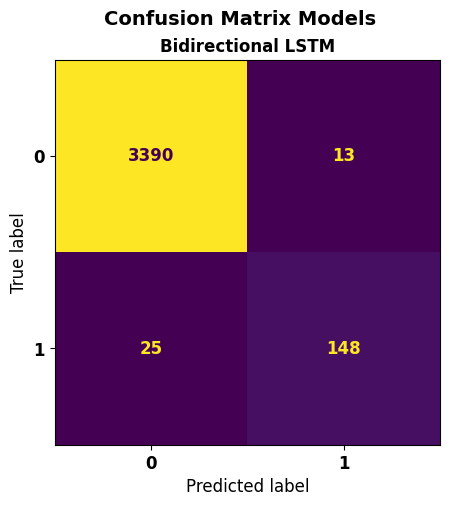

In [ ]:
import logging
import matplotlib
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

font = {'family':'normal','weight':'bold','size':12}
plt.rc('font', **font)

f, axes = plt.subplots(1, 1, figsize=(5,5))
i=0
#axes = axes.ravel()
f.suptitle("Confusion Matrix Models", fontsize=14, fontweight='bold')
if 1==1:
    mName = 'Bidirectional LSTM'
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred))
    disp.plot(ax=axes, values_format='.20g')
    axes.grid(False)
    disp.ax_.set_title(mName,fontweight='bold',fontsize=12)
    disp.im_.colorbar.remove()
    i=i+1

plt.show()

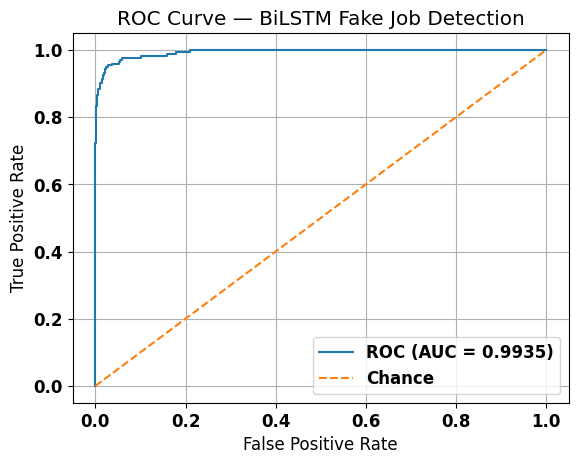

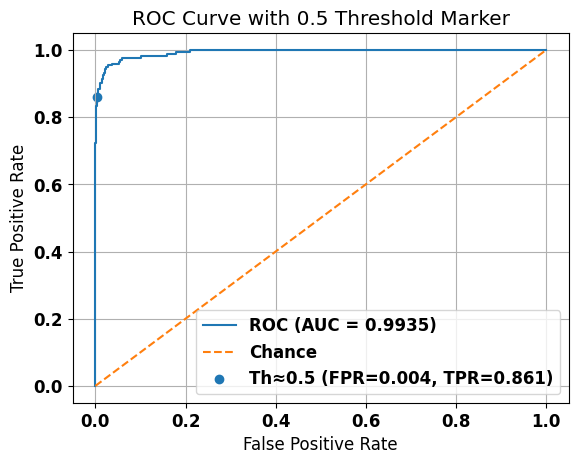

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

# 1) Get probability scores on the test set (NOT the 0/1 preds)
y_proba = bilstm_model.predict(
    [test_numeric, test_title_enc, test_company_profile_enc,
     test_description_enc, test_benefits_enc, test_requirements_enc],
    batch_size=256, verbose=0
).ravel()

y_true = np.asarray(y_test).ravel()  # ensure 1-D

# 2) Compute ROC points and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)

# 3) Plot ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — BiLSTM Fake Job Detection')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 4) (Optional) mark the point closest to threshold=0.5
idx = (np.abs(thresholds - 0.5)).argmin()
plt.figure()
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Chance')
plt.scatter([fpr[idx]], [tpr[idx]], marker='o', label=f'Th≈0.5 (FPR={fpr[idx]:.3f}, TPR={tpr[idx]:.3f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with 0.5 Threshold Marker')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import (
    classification_report, roc_auc_score, accuracy_score,
    precision_recall_fscore_support
)

# --- 1) Print the full per-class report (as you already do)
print(classification_report(y_test, y_pred, digits=4))

# --- 2) Build a single-metric summary for comparison
# AUROC uses probabilities; the others use thresholded labels
auroc     = roc_auc_score(y_test, y_pred_proba)
accuracy  = accuracy_score(y_test, y_pred)

# Get class-wise precision/recall/F1 and pull the positive class (label=1)
prec, rec, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=[0, 1]
)
precision_pos = float(prec[1])
recall_pos    = float(rec[1])
f1_pos        = float(f1[1])

metrics = {
    "auroc":     float(auroc),
    "accuracy":  float(accuracy),
    "precision": precision_pos,  # class 1
    "recall":    recall_pos,     # class 1
    "f1_score":  f1_pos          # class 1
}

# --- 3) Compare to your targets
targets = {
    "auroc": 0.91,
    "accuracy": 0.9871,
    "precision": 0.89,
    "recall": 0.83,
    "f1_score": 0.86
}

print("\n=== Target Check ===")
for metric, target_value in targets.items():
    actual_value = metrics[metric]
    verdict = "Target met" if actual_value >= target_value else "Target NOT met"
    print(f"{metric:9s}: {actual_value:.4f} — {verdict} (threshold {target_value:.4f})")

print(f"\nAchieved F1 (class 1) = {metrics['f1_score']:.4f}, "
      f"target {'met' if metrics['f1_score'] >= targets['f1_score'] else 'NOT met'}")


              precision    recall  f1-score   support

           0     0.9927    0.9962    0.9944      3403
           1     0.9193    0.8555    0.8862       173

    accuracy                         0.9894      3576
   macro avg     0.9560    0.9258    0.9403      3576
weighted avg     0.9891    0.9894    0.9892      3576


=== Target Check ===
auroc    : 0.9935 — Target met (threshold 0.9100)
accuracy : 0.9894 — Target met (threshold 0.9871)
precision: 0.9193 — Target met (threshold 0.8900)
recall   : 0.8555 — Target met (threshold 0.8300)
f1_score : 0.8862 — Target met (threshold 0.8600)

Achieved F1 (class 1) = 0.8862, target met


# Save Model

In [ ]:
bilstm_model.save("/content/drive/MyDrive/final_bilstm.keras")